In [1]:
# imports
import numpy as np
import pandas as pd

import tensorflow as tf
import matplotlib.pyplot as plt
import keras.backend as K

from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split

In [2]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [3]:
# loading data
file_path = '../input/heart-disease-health-indicators-dataset/heart_disease_health_indicators_BRFSS2015.csv'
df = pd.read_csv(file_path)

In [4]:
# setting parameters
n_epochs=150
batch_size=256
lr=0.01
conf=0.5

In [5]:
#removing duplicates
df = df.drop_duplicates()

In [6]:
# checking skewness of classes
df['HeartDiseaseorAttack']. value_counts()

0.0    206064
1.0     23717
Name: HeartDiseaseorAttack, dtype: int64

In [7]:
df_pos=df[df['HeartDiseaseorAttack']==1]
df_neg=df[df['HeartDiseaseorAttack']==0]

In [8]:
df_neg.shape

(206064, 22)

In [9]:
#Undersampling to remove skewness of Dataset
df_neg=df_neg.sample(frac=0.1, replace=True, random_state=1)

In [10]:
df_neg.shape

(20606, 22)

In [11]:
df=pd.concat([df_pos, df_neg],ignore_index=True)

In [12]:
# shuffling
df = df.sample(frac = 1)

In [13]:
# separating the X and Y parts of dataset
y_df=df["HeartDiseaseorAttack"]
x_df = df.drop(['HeartDiseaseorAttack'], axis = 1)
x_df.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
19005,1.0,1.0,1.0,38.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,3.0,10.0,10.0,0.0,1.0,7.0,5.0,7.0
39866,1.0,1.0,1.0,35.0,0.0,0.0,2.0,1.0,1.0,0.0,...,1.0,1.0,4.0,5.0,0.0,0.0,1.0,8.0,4.0,5.0
29053,1.0,1.0,1.0,25.0,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,1.0,5.0,0.0,0.0,1.0,9.0,6.0,8.0
41405,1.0,1.0,1.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,2.0,0.0,2.0,0.0,1.0,7.0,2.0,5.0
38274,0.0,0.0,1.0,22.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,8.0,6.0,7.0


In [14]:
# columns that need to be normalised
cols=['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']

In [15]:
# normalising
x_df[cols] = (x_df[cols] - x_df[cols].min())/ (x_df[cols].max()- x_df[cols].min())

In [16]:
x_df.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
19005,1.0,1.0,1.0,0.302326,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.50,0.333333,0.333333,0.0,1.0,0.500000,0.8,0.857143
39866,1.0,1.0,1.0,0.267442,0.0,0.0,2.0,1.0,1.0,0.0,...,1.0,1.0,0.75,0.166667,0.000000,0.0,1.0,0.583333,0.6,0.571429
29053,1.0,1.0,1.0,0.151163,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.00,0.166667,0.000000,0.0,1.0,0.666667,1.0,1.000000
41405,1.0,1.0,1.0,0.197674,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.25,0.000000,0.066667,0.0,1.0,0.500000,0.2,0.571429
38274,0.0,0.0,1.0,0.116279,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.50,0.000000,0.000000,0.0,1.0,0.583333,1.0,0.857143


In [17]:
# converting to numpy arrays
x_train = x_df.to_numpy()
y_train = y_df.to_numpy()

In [18]:
# train-val-test split
x_train, x_test, y_train, y_test = train_test_split( x_train, y_train, test_size=0.15, random_state=42)
x_train, x_val, y_train, y_val = train_test_split( x_train, y_train, test_size=0.20, random_state=42)

In [19]:
y_train = y_train.reshape(y_train.shape[0],1)
y_test = y_test.reshape(y_test.shape[0],1)
y_val = y_val.reshape(y_val.shape[0],1)

In [20]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_val.shape)
print(y_val.shape)

(30139, 21)
(30139, 1)
(6649, 21)
(6649, 1)
(7535, 21)
(7535, 1)


In [21]:
# building the model
model=Sequential()
model.add(Dense(x_train.shape[0],input_dim=x_train.shape[1],activation='relu')) # input layer
model.add(Dense(128,activation='relu')) # hidden layers
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(1,activation='sigmoid')) # sigmoid output

2022-03-05 11:15:12.124653: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-05 11:15:12.222798: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-05 11:15:12.223513: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-05 11:15:12.225025: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [22]:
# setting up the learning scheduler
initial_learning_rate =lr
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=n_epochs,
    decay_rate=0.96,
    staircase=True)

In [23]:
# compiling the model
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule), 
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=conf),tf.keras.metrics.Recall(), 
                       get_f1])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30139)             663058    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3857920   
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 4,587,027
Trainable params: 4,587,027
Non-trainable params: 0
_________________________________________________________________


In [25]:
H = model.fit(x=x_train, y=y_train, epochs=n_epochs, batch_size=batch_size,
            validation_data=(x_val, y_val))

Epoch 1/150


2022-03-05 11:15:15.092934: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


118/118 [==============================] - 3s 9ms/step - loss: 0.6752 - binary_accuracy: 0.6105 - recall: 0.9780 - get_f1: 0.7292 - val_loss: 0.6552 - val_binary_accuracy: 0.6644 - val_recall: 0.9628 - val_get_f1: 0.7545
Epoch 2/150
118/118 [==============================] - 1s 8ms/step - loss: 0.6392 - binary_accuracy: 0.6976 - recall: 0.9208 - get_f1: 0.7652 - val_loss: 0.6170 - val_binary_accuracy: 0.7246 - val_recall: 0.9013 - val_get_f1: 0.7770
Epoch 3/150
118/118 [==============================] - 1s 7ms/step - loss: 0.6046 - binary_accuracy: 0.7221 - recall: 0.8681 - get_f1: 0.7692 - val_loss: 0.5829 - val_binary_accuracy: 0.7379 - val_recall: 0.8596 - val_get_f1: 0.7775
Epoch 4/150
118/118 [==============================] - 1s 7ms/step - loss: 0.5759 - binary_accuracy: 0.7306 - recall: 0.8346 - get_f1: 0.7677 - val_loss: 0.5569 - val_binary_accuracy: 0.7439 - val_recall: 0.8387 - val_get_f1: 0.7769
Epoch 5/150
118/118 [==============================] - 1s 6ms/step - loss: 0.554

In [26]:
# Evaluation
loss, accuracy, recall, f1_score = model.evaluate(x_test, y_test)
print('Loss: %.4f' % (loss))
print('Accuracy: %.2f' % (accuracy*100))
print('Recall: %.4f' % (recall))
print('F1 Score: %.4f' % (f1_score))

208/208 [==============================] - 1s 3ms/step - loss: 0.4981 - binary_accuracy: 0.7606 - recall: 0.8255 - get_f1: 0.7795
Loss: 0.4981
Accuracy: 76.06
Recall: 0.8255
F1 Score: 0.7795


Evaluating network...


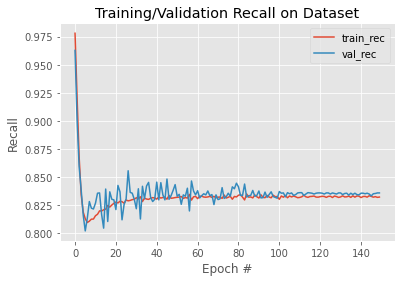

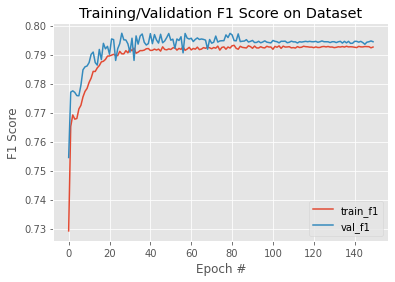

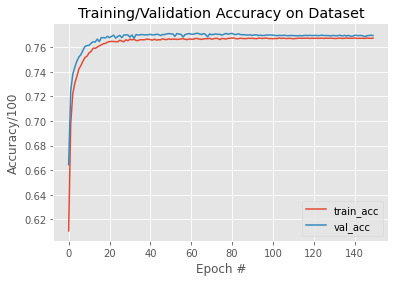

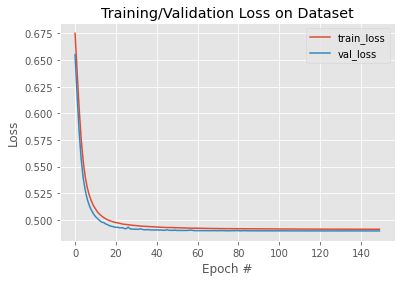

In [27]:
# evaluating and visual analysis of performance
print("Evaluating network...")
predictions = model.predict(x=x_test, batch_size=128)
# plot the training loss and accuracy
N = np.arange(0, n_epochs)
plt.style.use("ggplot")
plt.figure()

plt.title("Training/Validation Recall on Dataset")
plt.plot(N, H.history["recall"], label="train_rec")
plt.plot(N, H.history["val_recall"], label="val_rec")
plt.xlabel("Epoch #")
plt.ylabel("Recall")
plt.legend()
plt.show()

plt.title("Training/Validation F1 Score on Dataset")
plt.plot(N, H.history["get_f1"], label="train_f1")
plt.plot(N, H.history["val_get_f1"], label="val_f1")
plt.xlabel("Epoch #")
plt.ylabel("F1 Score")
plt.legend()
plt.show()

plt.title("Training/Validation Accuracy on Dataset")
plt.plot(N, H.history["binary_accuracy"], label="train_acc")
plt.plot(N, H.history["val_binary_accuracy"], label="val_acc")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy/100")
plt.legend()
plt.show()

plt.title("Training/Validation Loss on Dataset")
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()